A classifier to classify images of dogs and cats
In the implementation the use of ImageFolder to load data
is demonstrated

In [6]:
import torch
import torch.nn as nn
import torchvision

#for file handling
import os
import random
from pathlib import Path
import shutil

from torchvision import datasets
from torchvision.transforms import v2
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Subset


In [8]:
# Commenting this section because if run again will copy again

# Divide the dataset into training, validation, and test data sets using the 80/10/10 rule.

# Paths
# original_data_dir = '/home/jowusu1@windows.uwyo.edu/Documents/CNN-for-CatDog-Spectrograph-Classification/CatsDogsPSD'
# data_dir = '/home/jowusu1@windows.uwyo.edu/Documents/CNN-for-CatDog-Spectrograph-Classification/CatsDogsProcessed'
# # Categories
# categories = ["cats", "dogs"]

# # Create directory structure for processed dataset
# for split in ["train", "val", "test"]:
#     for category in categories:
#         os.makedirs(Path(data_dir) / split / category, exist_ok=True)

# # Separate images by category based on filenames
# cat_images = []
# dog_images = []

# # Collect images into category lists
# for file in os.listdir(original_data_dir):
#     if file.lower().startswith("cat"):  # Assuming filenames start with 'cat' or 'dog'
#         cat_images.append(file)
#     elif file.lower().startswith("dog"):
#         dog_images.append(file)

# # Function to split and move images
# def split_and_move(images, category):
#     random.shuffle(images)
#     n_total = len(images)
#     n_train = int(n_total * 0.8)
#     n_val = int(n_total * 0.1)

#     train_images = images[:n_train]
#     val_images = images[n_train : n_train + n_val]
#     test_images = images[n_train + n_val :]

#     # Copy images to respective folders
#     for img, split in zip([train_images, val_images, test_images], ["train", "val", "test"]):
#         for file in img:
#             src = Path(original_data_dir) / file
#             dst = Path(data_dir) / split / category / file
#             shutil.copy(src, dst)

# # Process and split both categories
# split_and_move(cat_images, "cats")
# split_and_move(dog_images, "dogs")

# print("Dataset split and copied successfully!")

In [10]:
#Data Augmentation
# transform_train = transforms.Compose([
#     transforms.Resize([64,48]),
#     transforms.ToTensor(),
# ])
#Create transforms
#Create a transform with resizing
#we did not do any scaling
#no normalisation which can lead to saturation
#does not work directly with image or pixel values
#convert ot floating point image
#normalise individually across each rgb channel
transform_train = v2.Compose([
    v2.Resize([64,48]),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [12]:
#Create dataset folders to load datasets using the datasets.ImageFolder class of the PyTorch framework.
#Create train and val dataset
data_dir = '/home/jowusu1@windows.uwyo.edu/Documents/CNN-for-CatDog-Spectrograph-Classification/CatsDogsProcessed'
train_dataset = datasets.ImageFolder(data_dir+'/train',
                                     transform = transform_train)
val_dataset = datasets.ImageFolder(data_dir+'/val',
                                     transform = transform_train)
test_dataset = datasets.ImageFolder(data_dir+'/test',
                                     transform = transform_train)

print('Train Set: ',len(train_dataset))
print('Valid Set: ',len(val_dataset))
print('Test Set: ',len(test_dataset))
print(train_dataset[0][0].shape)


Train Set:  221
Valid Set:  27
Test Set:  29
torch.Size([3, 64, 48])


In [14]:
#Create dataloaders for training and validation data sets
batch_size = 8

torch.manual_seed(1)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(val_dataset, batch_size, shuffle=False)
print(len(train_dl))
print(len(valid_dl))


28
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 134, 102)


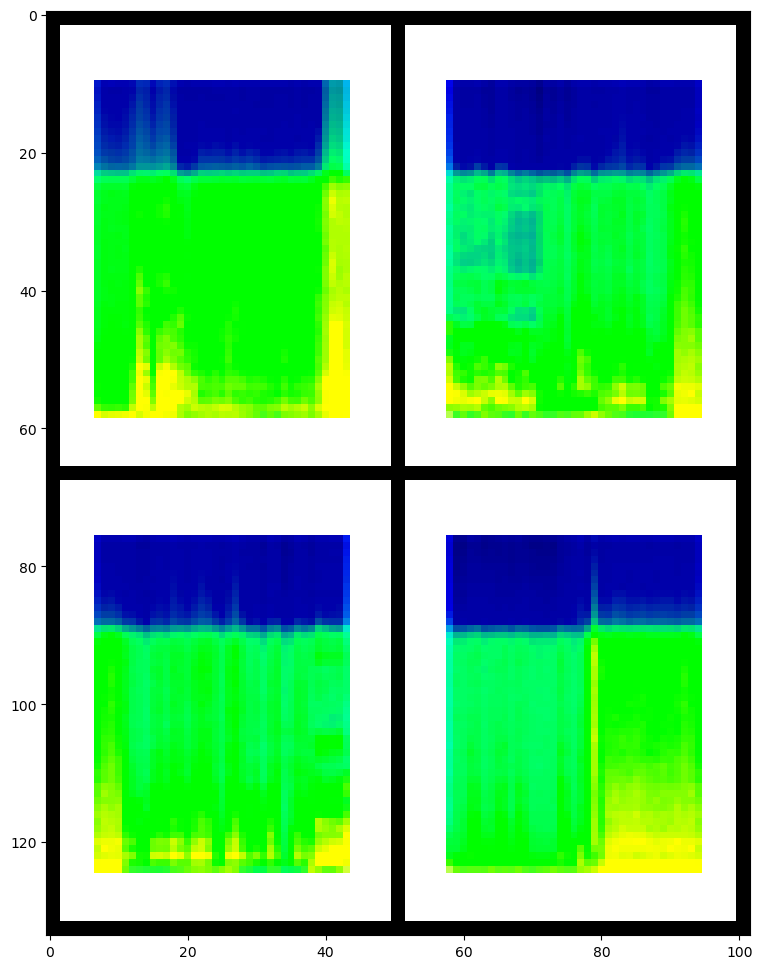

In [16]:
#Display Sample Images
samples, labels = next(iter(DataLoader(train_dataset, batch_size=4, shuffle=True)))
plt.figure(figsize=(16,12))
grid_imgs = torchvision.utils.make_grid(samples[:4], nrow=2)
np_grid_imgs = grid_imgs.numpy()

"""Display the shape of the grid containing four images, 
The black border will increase the size."""
print(np_grid_imgs.shape)
#imshow of matplotlib requires the images in the format(WHC)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.show()


In [18]:
#Build the CNN Architecture
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, \
                                    kernel_size=3, padding=1))
#Should be set to the number of outputs of the previous layer 
model.add_module('BN1',nn.BatchNorm2d(32)) # not done after pooling which is also a form of normalization
#Add a dropout layer
# can be done after AF, or maxpool
# typically in a CNN is added in the Fully connec layer if no improvement, is done at CNN layer
model.add_module('conv1_dropout',nn.Dropout(p=0.3))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, \
                                    kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, \
                                    kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())        
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, \
                                    kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.MaxPool2d(kernel_size=2))

# Added additional layers to increase depth
model.add_module('conv5', nn.Conv2d(in_channels=256, out_channels=128,\
                                    kernel_size=3, padding=1))
model.add_module('relu5', nn.ReLU())

#Add an average pooling
model.add_module('pool5', nn.AvgPool2d(kernel_size=3))


In [20]:
#Flatten the output of the last pooling layer
model.add_module('flatten', nn.Flatten())


In [22]:
#Add a fully connected output layer with a single neuron
model.add_module('fc', nn.Linear(128, 1)) 
model.add_module('sigmoid', nn.Sigmoid()) # this is a binary classification so we can use sigmoid


In [24]:
model


Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_dropout): Dropout(p=0.3, inplace=False)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (pool5): AvgPool2d(kernel

In [28]:
#setup to use GPU
device = torch.device("cuda:0")
model = model.to(device)


In [30]:
#Use Binary Cross Entropy loss function
loss_fn = nn.BCELoss()
#Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [32]:
#Define a training function
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device)  
            pred = model(x_batch)[:, 0]

            loss = loss_fn(pred, y_batch.float())
            # l1_regularization = 0.0 # initialize in each batch iteration to zero
            # for param in model.parameters():
            #     l1_regularization += torch.norm(param,1)
            # loss = loss_fn(pred, y_batch.float()) + 0.0001*l1_regularization  # added L1 regularization
            # # L1 is reducing the variance information and taking all the negative values of the weights out
            # l2_regularization = 0.0
            # for param in model.parameters():
            #     l2_regularization += torch.norm(param,2)  #does square of value
            # loss = loss_fn(pred, y_batch.float()) + 0.0001*l2_regularization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float() # set the level to choose which class, >0.5 is one class 
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} \
        val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train,\
    accuracy_hist_valid


In [34]:
#Begin Training
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5928         val_accuracy: 0.5926
Epoch 2 accuracy: 0.5928         val_accuracy: 0.5926
Epoch 3 accuracy: 0.6199         val_accuracy: 0.8148
Epoch 4 accuracy: 0.8552         val_accuracy: 0.8889
Epoch 5 accuracy: 0.8552         val_accuracy: 0.8889
Epoch 6 accuracy: 0.8778         val_accuracy: 0.9630
Epoch 7 accuracy: 0.8914         val_accuracy: 0.9259
Epoch 8 accuracy: 0.9050         val_accuracy: 0.8889
Epoch 9 accuracy: 0.9276         val_accuracy: 0.9630
Epoch 10 accuracy: 0.9140         val_accuracy: 0.9630
Epoch 11 accuracy: 0.9774         val_accuracy: 0.9630
Epoch 12 accuracy: 0.9638         val_accuracy: 0.9259
Epoch 13 accuracy: 0.9864         val_accuracy: 0.8889
Epoch 14 accuracy: 0.9548         val_accuracy: 0.9630
Epoch 15 accuracy: 0.9774         val_accuracy: 1.0000
Epoch 16 accuracy: 0.9683         val_accuracy: 0.9630
Epoch 17 accuracy: 0.9819         val_accuracy: 0.9259
Epoch 18 accuracy: 0.9638         val_accuracy: 1.0000
Epoch 19 accuracy: 

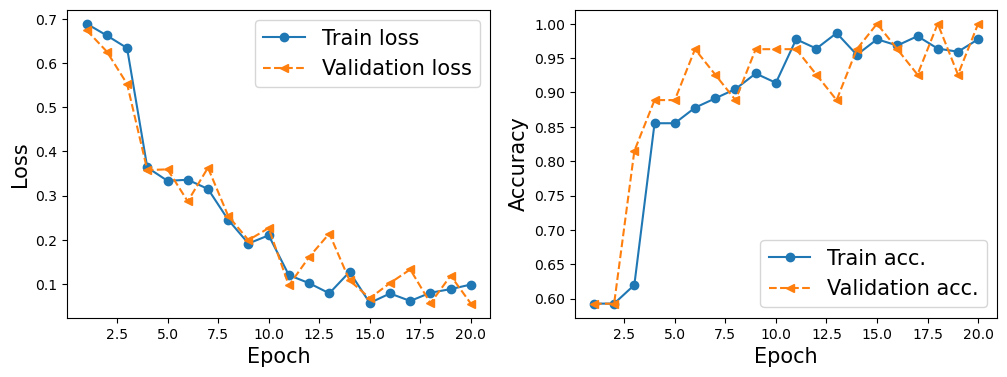

In [36]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()
#need more epochs for training, when they trend together then we can see if it is overfitting, underfitting or is not learning and saturates. 


In [44]:
#Evaluate model performance with test data
test_dataset = datasets.ImageFolder(data_dir+'/test',transform=transform_train)
print('Test Set: ',len(test_dataset))
test_dl = DataLoader(test_dataset,batch_size, shuffle=False)
accuracy_test = 0.0

#Set the model for evaluation using the model on GPU
model.eval()
with torch.no_grad():
    for x_batch,y_batch in test_dl:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:,0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()

accuracy_test /= len(test_dataset)
print('Test Accuracy: {0:.4f}'.format(accuracy_test))
# generalizing well because is similar to the training accuracy
        

Test Set:  29
Test Accuracy: 1.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

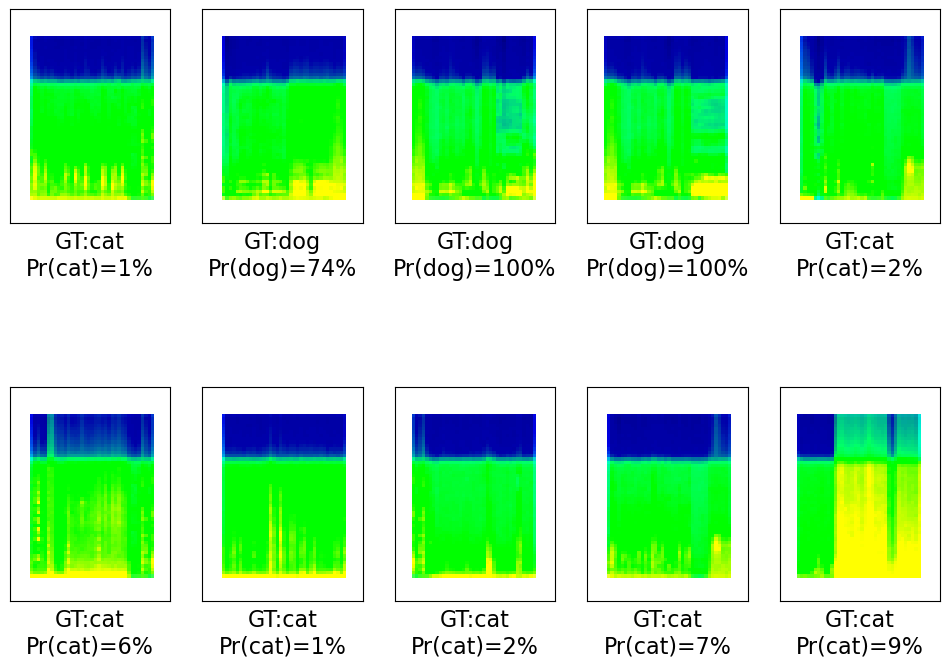

In [46]:
#Display the results for a small subset of test data with their probabilities
model = model.to('cpu')
samples, labels = next(iter(DataLoader(test_dataset, batch_size=32, shuffle=True)))
pred = model(samples)[:,0]*100
fig = plt.figure(figsize=(12,9))
for j in range(10,20):
    ax = fig.add_subplot(2,5,j-10+1)
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(samples[j].permute(1,2,0))
    if labels[j] == 1:
        label = 'dog'
    else:
        label = 'cat'
    ax.text(
        0.5,-0.15,
        f'GT:{label:s}\nPr({label:s})={pred[j]:.0f}%',
        size = 16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes
    )
plt.show() 
#change softmax to get the actual probablity since we used sigmoid earlier 